In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import torch
from pathlib import Path
from grammar_ninja.data.grammar.preprocessing import PromptTemplate, PROMPT_TEMPLATE_PATHS
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
%load_ext autoreload
%autoreload 2

Seed set to 42


In [7]:
DATA_DIR = Path("/projectnb/cs505ws/projects/grammar_ninja_alavaee/data/grammar")

In [8]:
coedit = pd.read_parquet(DATA_DIR.joinpath("coedit", "processed", "train.parquet"))

In [9]:
coedit

,task,instruction,sentence,corrected_sentence
0,gec,Remove all grammatical errors from this text,"For example, countries with a lot of deserts c...","For example, countries with a lot of deserts c..."
1,gec,Improve the grammaticality,"As the number of people grows, the need of hab...","As the number of people grows, the need for a ..."
2,gec,Improve the grammaticality of this sentence,Besides some technologically determinists that...,Besides some technological determinists that a...
3,gec,Remove all grammatical errors from this text,Safety is one of the crucial problems that man...,Safety is one of the crucial problems that man...
4,gec,Fix grammaticality in this sentence,On one hand more and more virus and hack can a...,"On the one hand, more and more viruses and hac..."
...,...,...,...,...
69066,clarity,Rewrite this sentence for clarity,The Habsburgyears also ushered in the Spanish ...,"During the Habsburg's period, Spain ushered in..."
69067,clarity,Rewrite the sentence more clearly,The Habsburgyears also ushered in the Spanish ...,The Habsburgyears also ushered in the Spanish ...
69068,clarity,Make this sentence more readable,"In 2019, he was traded to the Astros in a bloc...","In 2019, he was traded to the Astros in a bloc..."
69069,clarity,Use clearer wording,"In 2019, he was traded to the Astros in a bloc...","In 2019, he was traded to the Astros in a bloc..."


In [11]:
input_text_lengths = coedit["sentence"].map(lambda t: len(t)).to_numpy()

In [12]:
prompt_template = PromptTemplate(prompt_template_path=PROMPT_TEMPLATE_PATHS / "simple.txt")

In [14]:
print(prompt_template.format_prompt(dict(instruction="Correct this sentence",
                                    sentence="Hellow there!",
                                    corrected_sentence="Hello there!")))

Correct this sentence

### Sentence:
Hellow there!

### Corrected Sentence:
Hello there!


In [18]:
inputs = coedit.apply(
    lambda row: prompt_template.format_prompt(dict(
        instruction=row["instruction"],
        sentence=row["sentence"],
        corrected_sentence=row["corrected_sentence"],
    )),
    axis=1,
)

In [19]:
CACHE_DIR = "/projectnb/cs505ws/projects/grammar_ninja_alavaee/model_weights"
MODEL_ID = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=MODEL_ID,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    local_files_only=True,
    cache_dir=CACHE_DIR
)
tokenizer.pad_token = tokenizer.eos_token

In [20]:
tokenized_inputs = tokenizer(inputs.tolist())

In [21]:
lengths = [len(tok) for tok in tokenized_inputs["input_ids"]]

In [24]:
tokenized_inputs[0]

Encoding(num_tokens=95, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [25]:
inputs[0]

'Remove all grammatical errors from this text\n\n### Sentence:\nFor example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.\n\n### Corrected Sentence:\nFor example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'

(array([3.3265e+04, 2.5861e+04, 7.5420e+03, 2.0970e+03, 2.2300e+02,
        5.0000e+01, 1.9000e+01, 7.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 29. ,  64.7, 100.4, 136.1, 171.8, 207.5, 243.2, 278.9, 314.6,
        350.3, 386. , 421.7, 457.4, 493.1, 528.8, 564.5, 600.2, 635.9,
        671.6, 707.3, 743. ]),
 <BarContainer object of 20 artists>)

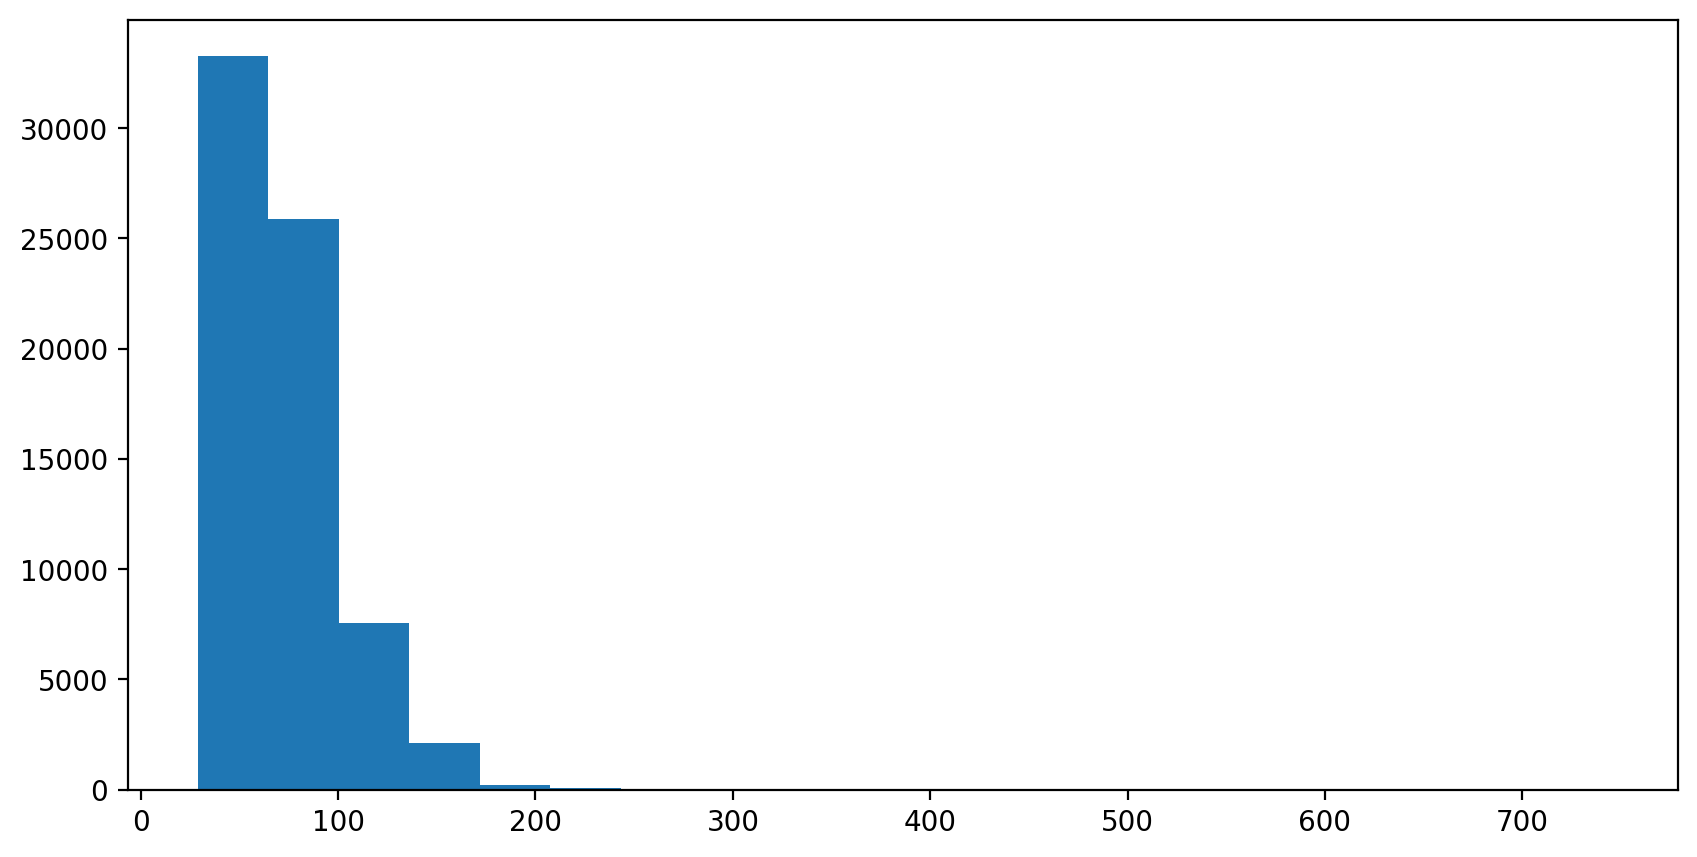

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.hist(lengths, bins=20)

In [26]:
np.array(lengths).mean()

73.35131965658525